In [1]:
import pandas as pd
import os

In [2]:
def get_data_csv(path, file_nm):
    csv_path = os.path.join(path, file_nm)
    return pd.read_csv(csv_path)


In [3]:
COSTARICA_PATH = "/home/stationedabroad/Documents/Kaggle/CostaRicaPoverty"
file_name_trn = "train.csv"
file_name_tst = "test.csv"

df_train = get_data_csv(COSTARICA_PATH, file_name_trn)
df_test = get_data_csv(COSTARICA_PATH, file_name_tst)

In [4]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


In [5]:
# derive train/validation split using household ID
from sklearn.model_selection import train_test_split

def get_validationsplit_by_household(df, ratio, hh='idhogar'):
    hh_id = df[hh].unique()
    np.random.shuffle(hh_id)
    test_size = int(ratio * len(hh_id))
    train_id = hh_id[test_size:]
    test_id = hh_id[:test_size]
    return df.loc[df[hh].isin(train_id)], df.loc[df[hh].isin(test_id)]
    


In [136]:
# function to remove households which have no "head" of household
num_of_heads = df_train.parentesco1.value_counts()[1]
num_of_households = df_train.idhogar.nunique()

def remove_headless_households(df):
    l_df = df.copy()
    indices_of_HH_missing_head = []
    for i, v in enumerate((l_df[['parentesco1', 'idhogar']].groupby('idhogar').sum()==0).values):
        if v[0]:
            indices_of_HH_missing_head.append(i)
    idhogar_of_HH_missing_head = l_df[['parentesco1', 'idhogar']].groupby('idhogar').sum().iloc[indices_of_HH_missing_head].index
    l_df['const'] = 1
    return l_df.loc[l_df.idhogar.isin(idhogar_of_HH_missing_head)==False].loc[:, l_df.columns != 'const'], l_df.loc[l_df.idhogar.isin(idhogar_of_HH_missing_head)==True].groupby('idhogar')['const'].count()

In [210]:
def make_feature_list_dupes(feature, n):
    return [feature+str(i) for i in range(1, n+1)]

# grouping features
f_region = make_feature_list_dupes('lugar', 6)
f_area = make_feature_list_dupes('area', 2)
f_house_status = make_feature_list_dupes('tipovivi', 5)
f_education = make_feature_list_dupes('instlevel', 9)
f_marital_status = make_feature_list_dupes('estadocivil', 7)
#f_marital_status = f_marital_status[1]
f_floor_status = make_feature_list_dupes('eviv', 3)
f_roof_status = make_feature_list_dupes('etecho', 3)
f_wall_status = make_feature_list_dupes('epared', 3)
f_waste_disp = make_feature_list_dupes('elimbasu', 6)
f_energy_source = make_feature_list_dupes('energcocinar', 4)
f_sanitation = ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']
f_electricity = ['public', 'planpri', 'noelec', 'coopele']
f_water = ['abastaguadentro', 'abastaguafuera', 'abastaguano']
f_roof_material = ['techozinc', 'techoentrepiso', 'techocane', 'techootro']
f_floor_material = ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']
f_wall_material = ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']
f_gender = ['male', 'female']
# combine in list
cons_feat_list = [('area', f_area), ('education', f_education), ('electricity', f_electricity), ('energy_source', f_energy_source), ('floor_material', f_floor_material), ('floor_status', f_floor_status), ('gender', f_gender), ('house_status', f_house_status), ('marital_status', f_marital_status), ('region', f_region), ('roof_material', f_roof_material), ('roof_status', f_roof_status), ('sanitation', f_sanitation), ('wall_material', f_wall_material), ('wall_status', f_wall_status), ('waste_disp', f_waste_disp), ('water', f_water)]


In [157]:
# consolidate function
def derive_score(l):
    return np.array(l).argmax()

def consolidate_features(df, features):
    """features in cell 280 are spread across many columns e.g. region comes as 6 columns, with only one being
       set (majority of the time). This function takes each feature to be grouped, if feature is checked zero
       or more than 1 times - error and assign NaN, else use argmax to assign a categorical variable from
       1 - n"""
    l_df = df.copy()
    for nm, feats in features:
        l_df[nm] = np.where(l_df[feats].sum(axis=1) == 0, np.nan, l_df[feats].values.argmax(axis=1)+1) 
    return l_df   

In [205]:
# Consolidate Features test: Check which features have no values for the feature set - which we shall Impute later
def pre_check_nulls(df):
    known_nulls = {}
    print("checking nulls ...")
    for nm, feats in cons_feat_list:
        try:
            df_tmp = df[feats].sum(axis=1)
            if len(df_tmp) != df_tmp.sum():
                known_nulls[nm] = len(df_tmp.loc[df_tmp!=1])
                print('problem nulls : %s # of issues %i' % (nm, len(df_tmp.loc[df_tmp!=1])))
        except:
            print('problem %s, %s' % (nm, feats))
    return known_nulls       
            
def post_check_values(df):
# Consoliate Features test: test to see if consolidation works (checknulls, check value counts)
    print("checking values ...")
    for nm, feats in cons_feat_list:
        num_of_values = df[nm].nunique()
        num_of_nulls = df[nm].isnull().sum()
        if num_of_values != len(feats):
            print("Consolidated values %i for %s do not match original of %i" % (num_of_values, nm, len(feats) ))
        if nm in known_nulls:    
            if num_of_nulls != known_nulls[nm]:
                print("Null values %i for %s do not match original of %i" % (num_of_nulls, nm, known_nulls[nm]) )


In [295]:
# refresh data
df_train_tmp = df_train.copy()


In [296]:
### 1. Remove households with no HoH
df_train_tmp, df_train_removed_rows = remove_headless_households(df_train_tmp)
print("1. Removed %i entries, households with no HoH" % (df_train_removed_rows.sum()))
### 2. Remove features with too many NaN (though 'estadocivil1' does not make sense, include for now)
nan_characteristics = ['v2a1', 'v18q1', 'rez_esc']
df_train_tmp = df_train_tmp.drop(nan_characteristics, axis=1)
print("2. Following characteristics removed due to large number of null values")
print(nan_characteristics)
### 3. Consolidate features - Impute values for NaN
print("3. Consoliate Features")
#f_marital_status.pop(0)
df_train_tmp = consolidate_features(df_train_tmp, cons_feat_list)
# check null values
nulls = pre_check_nulls(df_train_tmp)
# post check values
post_check_values(df_train_tmp)

### 4. Fill null values in consolidated features
print("4. Fill nan values")
# get mean values first
mean_education = np.round(df_train_tmp.education.mean()) # cieling mean of household
mean_electricity = np.round(df_train_tmp.electricity.mean()) # get HH value
mean_roof_material = np.round(df_train_tmp.roof_material.mean()) # get HH value
# then fill - for education we impute mean from household, but for roof_material and electricity we fill values 
# from other household members

### 5. feature derivation

### N. Finally filter a dataframe with only HoH for the algorithm



1. Removed 23 entries, households with no HoH
2. Following characteristics removed due to large number of null values
['v2a1', 'v18q1', 'rez_esc']
3. Consoliate Features
checking nulls ...
problem nulls : education # of issues 3
problem nulls : electricity # of issues 15
problem nulls : roof_material # of issues 66
checking values ...
Consolidated values 5 for waste_disp do not match original of 6
4. Fill nan values


In [344]:
#df_train.loc[df_train.idhogar.isin(n)==False].shape
#l=f_marital_status.copy()
#df_train_tmp[f_marital_status]#.sum(axis=1)
#df_train_tmp.electricity.fillna?
household_id_missing_educ = df_train_tmp.loc[df_train_tmp.education.isnull()]['idhogar'].values
household_id_missing_educ
#df_train_tmp.loc[df_train_tmp.education.isnull()]
#df_train_tmp[f_electricity].loc[df_train_tmp.idhogar.isin(household_id_missing_elec)].sum(axis=1)
# 1476 1481 6728

#df_train_tmp[f_education][df_train_tmp[f_education].sum(axis=1)==0]
#print(df_train_tmp.iloc[1476]['idhogar'])
household_id_missing_educ
edu_mean = round(df_train_tmp.loc[df_train_tmp.idhogar=='84cd19747']['education'].mean())
#df_train_tmp.education.fillna(4, inplace=True)
df_train_tmp.loc[df_train_tmp.idhogar=='84cd19747']['education']

def fill_nulls_for_household_id(df, feats, method=np.mean):
    l_df = df.copy()
    for feat in feats:
        for id in set(l_df.loc[l_df[feat].isnull()]['idhogar'].values):
            m = method(l_df.loc[l_df.idhogar==id][feat])
            null_idx = l_df.loc[(l_df['idhogar']==id) &  (l_df['idhogar'].isnull())].index
            [l_df[feat].set_value(i, m) for i in null_idx]
    return l_df       
            

In [316]:
#df_train_tmp.loc[df_train_tmp.idhogar=='84cd19747']['education']
household_id_missing_educ
 

array(['84cd19747', '44e76cc86'], dtype=object)

In [322]:
#df_train_tmp.education.set_value(1476, 4)
print(df_train_tmp.loc[df_train_tmp.idhogar=='84cd19747']['education'].values)
print(df_train_tmp.loc[df_train_tmp.idhogar=='84cd19747']['education'].index)

[  4.   3.   5.   4.   2.  nan]
Int64Index([1476, 1477, 1478, 1479, 1480, 1481], dtype='int64')


In [343]:
def test(l, m=np.mean):
    return m(l)

#test(df_train_tmp.education)
df_train_tmp.loc[(df_train_tmp.idhogar=='84cd19747') & (df_train_tmp.education.isnull())].index

Int64Index([1481], dtype='int64')

In [38]:
# 1. 
from sklearn.base import BaseEstimator, TransformerMixin

'v2a1', 'v18q1', 'rez_esc', 'estadocivil1'

class dropAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, drop_attr):
        self.drop_attributes = drop_attr
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.drop_attributes:
            

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [66]:
ones = np.ones(10)
zees = np.zeros(10)
p=np.c_[ones, zees]
p.dr

this list of household's has no head of households so should be excluded


In [677]:
#f_parents = make_feature_list_dupes('parentesco', 12)
df_train[f_parents].loc[df_train.idhogar=='6b1b2405f']


,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12
7438,0,1,0,0,0,0,0,0,0,0,0,0
7439,0,0,1,0,0,0,0,0,0,0,0,0
7440,0,0,1,0,0,0,0,0,0,0,0,0


In [135]:
# function to check which features have large # of NaN
def large_column_set_nulls(df):
    cols = df.columns
    size = len(df)
    return [(col, df[col].isnull().sum(), df[col].nunique()) for col in cols]



In [161]:
### DROP columns and keep subset
null_set_columns = large_column_set_nulls(df_train)
df_train_subset = df_train.drop(['v2a1', 'v18q1', 'rez_esc', 'estadocivil1' ], axis=1)

In [765]:
# check which columns have a large number of null values, these can be excluded from the algorithm
for i in null_set_columns:
    if i[1] == 0:
        print(i)

('Id', 0, 9557)
('hacdor', 0, 2)
('rooms', 0, 11)
('hacapo', 0, 2)
('v14a', 0, 2)
('refrig', 0, 2)
('v18q', 0, 2)
('r4h1', 0, 6)
('r4h2', 0, 9)
('r4h3', 0, 9)
('r4m1', 0, 6)
('r4m2', 0, 7)
('r4m3', 0, 9)
('r4t1', 0, 7)
('r4t2', 0, 11)
('r4t3', 0, 13)
('tamhog', 0, 13)
('tamviv', 0, 14)
('escolari', 0, 22)
('hhsize', 0, 13)
('paredblolad', 0, 2)
('paredzocalo', 0, 2)
('paredpreb', 0, 2)
('pareddes', 0, 2)
('paredmad', 0, 2)
('paredzinc', 0, 2)
('paredfibras', 0, 2)
('paredother', 0, 2)
('pisomoscer', 0, 2)
('pisocemento', 0, 2)
('pisoother', 0, 2)
('pisonatur', 0, 2)
('pisonotiene', 0, 2)
('pisomadera', 0, 2)
('techozinc', 0, 2)
('techoentrepiso', 0, 2)
('techocane', 0, 2)
('techootro', 0, 2)
('cielorazo', 0, 2)
('abastaguadentro', 0, 2)
('abastaguafuera', 0, 2)
('abastaguano', 0, 2)
('public', 0, 2)
('planpri', 0, 2)
('noelec', 0, 2)
('coopele', 0, 2)
('sanitario1', 0, 2)
('sanitario2', 0, 2)
('sanitario3', 0, 2)
('sanitario5', 0, 2)
('sanitario6', 0, 2)
('energcocinar1', 0, 2)
('energ

In [11]:
# FEATURES!!!
# avg years of schooling
# consolidate r4t3, tamhog, tamviv, hhsize

1     602
2    3383
3    3985
4    1184
5     299
6     100
8       4
Name: bedrooms, dtype: int64

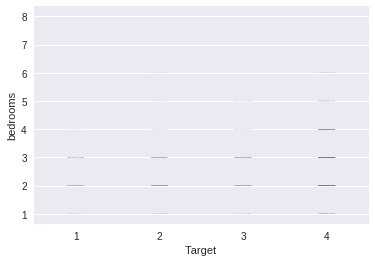

In [244]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
#plt.xticks(np.arange(1,14))
#plt.xlabel("number of family members per houehold")
#plt.hist(df_train.idhogar.value_counts().values)
#jitter = np.random.rand(df_train.Target.count())
#df_train.plot(kind='scatter', x='Target', y='bedrooms', figsize=(20,10), alpha=0.1)


sns.stripplot(x='Target', y='bedrooms', data=df_train, jitter=True, alpha=0.1, size=0.5)
sns.despine()
df_train.bedrooms.value_counts().sort_index()

In [134]:
# household members - largest household (just one) has 13 members ...
#df_train.idhogar.value_counts()[df_train.idhogar.value_counts() >5].shape
# Number of households
number_of_households = df_train_subset.idhogar.value_counts().shape[0]
print("Total number of households in dataset %i" % number_of_households )
print("Mean people per household %f" % df_train.idhogar.value_counts().mean())
print("Median people per household %f" % df_train.idhogar.value_counts().median())
print("Mode people per household %f" % df_train.idhogar.value_counts().mode())
df_train_subset.idhogar.nunique()

Total number of households in dataset 2988
Mean people per household 3.198461
Median people per household 3.000000
Mode people per household 3.000000


In [ ]:
df_train.Target.hist()


In [384]:
type(df_train.loc[df_train.idhogar=='1ed926340'].loc[7848][1])

numpy.float64

In [100]:
import seaborn as sns
sns.stripplot?


In [35]:

#sns.stripplot(x=df_train_subset.floor_material, y=df_train_subset.wall_material, jitter=0.4, size=8, alpha=0.2)

In [91]:
df_train.tamhog.value_counts().sort_index()

1      386
2     1362
3     2258
4     2451
5     1590
6      819
7      364
8       96
9       90
10      60
11      44
12      24
13      13
Name: tamhog, dtype: int64

In [83]:
df_train.parentesco1.value_counts()

0    6584
1    2973
Name: parentesco1, dtype: int64

In [67]:
#df_train.overcrowding.value_counts().sort_index()

In [277]:
## consolidate features
# REGION (lugar*), 
# AREA (area*)
# HOUSE STATUS (tipovivi*)
# EDUCATION LEVEL (instlevel*),
# FAMILY MEMBER (parentesco*) - not needed as we will crate aggregated household set based on head of HH
# drop estadocivil1 (not needed) - Done
df_train_subset['estadocivil1'] = df_train['estadocivil1']
# MARITAL STATUS (estadocivil*)
# Gender (male=0 and female=1)
#df_train_subset['gender'] = np.where(df_train_subset['male']==1, 0, 1)


# FLOOR STATUS (eviv*)
# ROOF STATUS (etecho*)
# WALL STATUS (epared*) 
# WASTE DISP (elimbasu*),
# SOURCE OF ENERGY (energcocinar*)
# SANITATION (sanitario*)
# ELECTRICITY (public, planpri, noelec, coopele)
# WATER (abastagua*)
# ROOF MATERIAL (techozinc, techoentrepiso, techocane, techootro)
# FLOOR MATERIAL (pisomoscer, pisocemento, pisoother, pisonatur, pisonotiene, pisomadera)
# WALL MATERIAL (many ...)


In [278]:
a.argmax()
df_train_subset[['male', 'female']].head()

,male,female
0,1,0
1,1,0
2,0,1
3,1,0
4,0,1


In [69]:
def make_feature_list_dupes(feature, n):
    return [feature+str(i) for i in range(1, n+1)]

In [70]:
# grouping features
f_region = make_feature_list_dupes('lugar', 6)
f_area = make_feature_list_dupes('area', 2)
f_house_status = make_feature_list_dupes('tipovivi', 5)
f_education = make_feature_list_dupes('instlevel', 9)
f_marital_status = make_feature_list_dupes('estadocivil', 7)
#f_marital_status = f_marital_status[1]
f_floor_status = make_feature_list_dupes('eviv', 3)
f_roof_status = make_feature_list_dupes('etecho', 3)
f_wall_status = make_feature_list_dupes('epared', 3)
f_waste_disp = make_feature_list_dupes('elimbasu', 6)
f_energy_source = make_feature_list_dupes('energcocinar', 4)
f_sanitation = ['sanitario1', 'sanitario2', 'sanitario3', 'sanitario5', 'sanitario6']
f_electricity = ['public', 'planpri', 'noelec', 'coopele']
f_water = ['abastaguadentro', 'abastaguafuera', 'abastaguano']
f_roof_material = ['techozinc', 'techoentrepiso', 'techocane', 'techootro']
f_floor_material = ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera']
f_wall_material = ['paredblolad', 'paredzocalo', 'paredpreb', 'pareddes', 'paredmad', 'paredzinc', 'paredfibras', 'paredother']
f_gender = ['male', 'female']

In [71]:
cons_feat_list = [('area', f_area), ('education', f_education), ('electricity', f_electricity), ('energy_source', f_energy_source), ('floor_material', f_floor_material), ('floor_status', f_floor_status), ('gender', f_gender), ('house_status', f_house_status), ('marital_status', f_marital_status), ('region', f_region), ('roof_material', f_roof_material), ('roof_status', f_roof_status), ('sanitation', f_sanitation), ('wall_material', f_wall_material), ('wall_status', f_wall_status), ('waste_disp', f_waste_disp), ('water', f_water)]
#cons_feat_list_tmp = [('roof_material', f_roof_material)]

In [540]:
# Check which features have no values for the feature set - which we shall Impute later
known_nulls = {}
for nm, feats in cons_feat_list:
    try:
        df = df_train_subset[feats].sum(axis=1)
        if len(df) != df.sum():
            known_nulls[nm] = len(df.loc[df!=1])
            print('problem with : %s # of issues %i' % (nm, len(df.loc[df!=1])))
    except:
        print('problem %s, %s' % (nm, feats))
print(known_nulls)

problem with : education # of issues 3
problem with : electricity # of issues 15
problem with : roof_material # of issues 66
{'education': 3, 'electricity': 15, 'roof_material': 66}


In [524]:
# Check which features have no values for the feature set or incorrect values (from choice of 4 where
# only one is chosen, 2 for example are chosen)
for nm, feats in cons_feat_list:
    try:
        zero=df_train_subset['Id'][df_train_subset[feats].sum(axis=1)==0].count()
        gt_one=df_train_subset['Id'][df_train_subset[feats].sum(axis=1)>1].count()
        if zero:
            print('Zero value : %s # of issues %i' % (nm, zero))
        if gt_one:
            print('Greater than 1 value : %s # of issues %i' % (nm, gt_one)) 
    except:
        print('problem %s, %s' % (nm, feats))


Zero value : education # of issues 3
Zero value : electricity # of issues 15
Zero value : roof_material # of issues 66


In [555]:
# consolidate function
def derive_score(l):
    return np.array(l).argmax()

def consolidate_features(df, features):
    """features in cell 280 are spread across many columns e.g. region comes as 6 columns, with only one being
       set (majority of the time). This function takes each feature to be grouped, if feature is checked zero
       or more than 1 times - error and assign NaN, else use argmax to assign a categorical variable from
       1 - n"""
    l_df = df.copy()
    for nm, feats in features:
        l_df[nm] = np.where(l_df[feats].sum(axis=1) == 0, np.nan, l_df[feats].values.argmax(axis=1)+1) 
    return l_df    


In [528]:
# keep a little copy
df_tmp = df_train_subset.copy()
#df_train_subset = df_tmp.copy()

In [556]:
# 1. consolidate features
df_train_subset = consolidate_features(df_train_subset, cons_feat_list)
# 2. test to see if consolidation works (checknulls, check value counts)
for nm, feats in cons_feat_list:
    num_of_values = df_train_subset[nm].nunique()
    num_of_nulls = df_train_subset[nm].isnull().sum()
    
    if num_of_values != len(feats):
        print("Consolidated values %i for %s do not match original of %i" % (num_of_values, nm, len(feats) ))
    if nm in known_nulls:    
        if num_of_nulls != known_nulls[nm]:
            print("Null values %i for %s do not match original of %i" % (num_of_nulls, nm, known_nulls[nm]) )


Consolidated values 5 for waste_disp do not match original of 6


In [559]:
# Waste_disp containing only 5 value categories is acceptable, since feature elimbasu5 has no values 
# at all set in the training set, when rn on test set, if there are values, then ... ?

1.0    8436
3.0     808
2.0     287
4.0      14
6.0      12
Name: waste_disp, dtype: int64

In [587]:
# remove original 'un'-consolidated features as not needed.
print("Original number of features with new ones %i" % len(df_train_subset.columns))
for nm, feats in cons_feat_list:
    try:
        df_train_subset = df_train_subset.drop(feats, axis=1)
        success = [True for f in feats if f in df_train_subset.columns]
        if success:
            print("Features %s dropped" % feats)
    except:
        print("already dropped %s " % feats)


Original number of features with new ones 79
already dropped ['area1', 'area2'] 
already dropped ['instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 'instlevel9'] 
already dropped ['public', 'planpri', 'noelec', 'coopele'] 
already dropped ['energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4'] 
already dropped ['pisomoscer', 'pisocemento', 'pisoother', 'pisonatur', 'pisonotiene', 'pisomadera'] 
already dropped ['eviv1', 'eviv2', 'eviv3'] 
already dropped ['tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5'] 
already dropped ['estadocivil1', 'estadocivil2', 'estadocivil3', 'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7'] 
already dropped ['lugar1', 'lugar2', 'lugar3', 'lugar4', 'lugar5', 'lugar6'] 
already dropped ['techozinc', 'techoentrepiso', 'techocane', 'techootro'] 
already dropped ['etecho1', 'etecho2', 'etecho3'] 
already dropped ['sanitario1', 'sanitario2', 'sanitario3', 'sanit

In [592]:
print("Number of features before consolidation %i and after %i" % (len(df_train.columns), len(df_train_subset.columns)))

Number of features before consolidation 143 and after 79


In [593]:
df_train_subset.head()

,Id,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,r4h3,...,floor_status,house_status,marital_status,region,roof_status,sanitation,wall_material,wall_status,waste_disp,water
0,ID_279628684,0,3,0,1,1,0,0,1,1,...,1.0,3.0,4.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0
1,ID_f29eb3ddd,0,4,0,1,1,1,0,1,1,...,2.0,3.0,4.0,1.0,2.0,2.0,5.0,2.0,1.0,1.0
2,ID_68de51c94,0,8,0,1,1,0,0,0,0,...,3.0,1.0,6.0,1.0,3.0,2.0,5.0,2.0,1.0,1.0
3,ID_d671db89c,0,5,0,1,1,1,0,2,2,...,3.0,3.0,7.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0
4,ID_d56d6f5f5,0,5,0,1,1,1,0,2,2,...,3.0,3.0,2.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0


In [ ]:
# fill null values


In [613]:
df_train_subset.reset_index()

,index,Id,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,...,floor_status,house_status,marital_status,region,roof_status,sanitation,wall_material,wall_status,waste_disp,water
0,0,ID_279628684,0,3,0,1,1,0,0,1,...,1.0,3.0,4.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0
1,1,ID_f29eb3ddd,0,4,0,1,1,1,0,1,...,2.0,3.0,4.0,1.0,2.0,2.0,5.0,2.0,1.0,1.0
2,2,ID_68de51c94,0,8,0,1,1,0,0,0,...,3.0,1.0,6.0,1.0,3.0,2.0,5.0,2.0,1.0,1.0
3,3,ID_d671db89c,0,5,0,1,1,1,0,2,...,3.0,3.0,7.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0
4,4,ID_d56d6f5f5,0,5,0,1,1,1,0,2,...,3.0,3.0,2.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0
5,5,ID_ec05b1a7b,0,5,0,1,1,1,0,2,...,3.0,3.0,2.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0
6,6,ID_e9e0c1100,0,5,0,1,1,1,0,2,...,3.0,3.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0
7,7,ID_3e04e571e,1,2,0,1,1,0,0,1,...,2.0,3.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
8,8,ID_1284f8aad,1,2,0,1,1,0,0,1,...,2.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
9,9,ID_51f52fdd2,1,2,0,1,1,0,0,1,...,2.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
